In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import MinMaxScaler

In [79]:
df = pd.read_csv('to_save/to_cluster_data.csv')

In [80]:
def get_batch(df, num_batch = (1, 1), size_img = (4096, 4096)):
    size_x_batch = size_img[0]//num_batch[0]
    size_y_batch = size_img[1]//num_batch[1]
    df['batch_x'] = (df['x'] // size_x_batch).astype(str)
    df['batch_y'] = (df['y'] // size_y_batch).astype(str)
    df['batch'] = df['batch_x'] + df['batch_y']
    df = df.drop(['batch_x', 'batch_y'], axis = 1)
    return df

In [81]:
df = get_batch(df)

# Norm data

In [31]:
df['x'] = df['x'] / 4096
df['y'] = df['y'] / 4096


In [96]:
df

,Unnamed: 0,x,y,val_KRA_RELIEF_ASPECT_100m,val_KRA_RELIEF_HEIGHT_100m,val_KRA_RELIEF_SLOPE_100m,val_KRA_SUNNY_DAYS_APR_OCT_100m,val_KRA_WATER_SEASONALYTY_100m,val_gausian_KRA_RELIEF_HEIGHT_100m,val_gaus_KRA_RELIEF_SLOPE_100m,...,val_mean_PREC_100m,val_mean_TAVG_100m,val_min_TAVG_100m,val_KRA_SOILTEXTURE_100m_0.0,val_KRA_SOILTEXTURE_100m_4.0,val_KRA_SOILTEXTURE_100m_5.0,val_KRA_SOILTEXTURE_100m_9.0,batch,pred,pred_batch
0,0,177,1518,270.000000,2.0,0.194353,131.0,0.0,8.0,0.194353,...,65535.000000,110.692129,26.063956,1,0,0,0,00,0,0_00
1,1,177,1519,90.000000,1.0,0.195172,131.0,0.0,8.0,0.195172,...,65535.000000,110.692129,26.063956,1,0,0,0,00,1,1_00
2,2,178,1517,315.000000,1.0,0.194952,131.0,0.0,8.0,0.194952,...,65535.000000,110.692129,26.063956,1,0,0,0,00,2,2_00
3,3,178,1518,180.000000,1.0,0.195776,131.0,0.0,8.0,0.195776,...,65535.000000,110.692129,26.063956,1,0,0,0,00,3,3_00
4,4,178,1519,202.683288,1.0,0.196599,131.0,0.0,8.0,0.196599,...,65535.000000,110.692129,26.063956,1,0,0,0,00,4,4_00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50958,50958,4041,2716,90.000000,6.0,8.535891,163.0,0.0,242.0,8.535891,...,133.500000,132.333333,71.000000,1,0,0,0,00,38477,38477_00
50959,50959,4042,2716,90.000000,5.0,8.511122,163.0,0.0,241.0,8.511122,...,133.500000,132.333333,71.000000,1,0,0,0,00,38478,38478_00
50960,50960,4049,2709,135.000000,1.0,7.915207,164.0,0.0,217.0,7.915207,...,133.416667,132.500000,70.000000,1,0,0,0,00,38479,38479_00
50961,50961,4050,2708,90.000000,1.0,7.832723,164.0,0.0,213.0,7.832723,...,133.416667,132.500000,70.000000,1,0,0,0,00,38480,38480_00


# clustering

In [35]:
def get_dbscan_pred_for_batch(eps):
    df = pd.read_csv('to_save/to_cluster_data.csv')
    df = get_batch(df)
    clf = MinMaxScaler()
    pred = clf.fit_transform(df[df.columns[3:-1]])
    df[df.columns[3:-1]] = pred
    
    batch_vals = df['batch'].unique()
    batch_arr = df['batch'].values
    for v in tqdm.tqdm(batch_vals):
        dbscan = DBSCAN(eps = eps, min_samples = 1)
        df_tmp = df[df['batch'] == v][df.columns[3:-1]]
        pred = dbscan.fit_predict(df_tmp)
        batch_arr[batch_arr == v] = pred
        del df_tmp, pred, dbscan
        
    df_ = pd.DataFrame(batch_arr, columns = ['pred'])
    df_.to_csv('cluster_pred\dbscan_' + str(eps) + '_without_xy.csv', index = False)
    print('FINISHED', eps)

In [77]:
for eps in [0.001, 0.0001, 0.00001]:
    get_dbscan_pred_for_batch(eps)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.14s/it]


FINISHED 0.001


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.02s/it]


FINISHED 0.0001


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.90s/it]

FINISHED 1e-05


In [37]:
get_dbscan_pred_for_batch(eps)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.94s/it]

FINISHED 0.01


In [82]:
t = pd.read_csv('cluster_pred\dbscan_' + str(0.001) + '_without_xy.csv')

In [83]:
df['pred'] = t['pred'].astype(str)

In [84]:
df['pred_batch'] = df['pred'] + '_' +df['batch']

In [58]:
np.median(df['pred_batch'].value_counts())

1.0

In [89]:
val = df['pred_batch'].value_counts()
val = val[val > 5]

In [98]:
df = df[df['pred_batch'].isin(val.index)]

In [99]:
df.to_csv('pred_cluster.csv', index = False)

In [2]:
df = pd.read_csv('pred_cluster.csv')

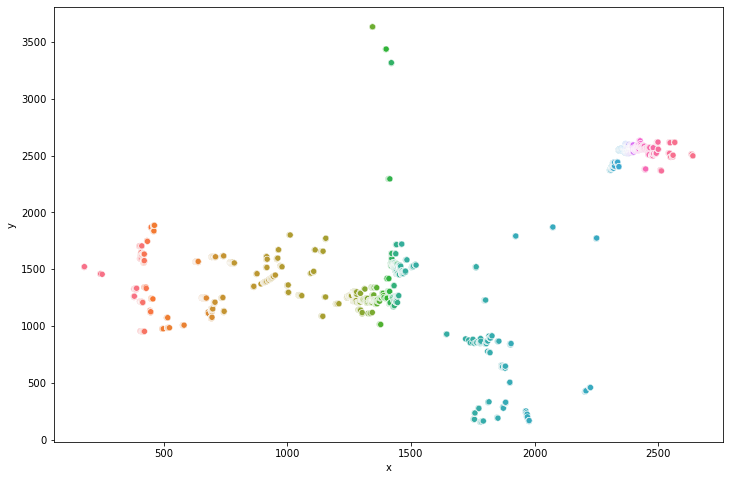

In [9]:
plt.figure(figsize = (12, 8))
sns.scatterplot(x = df['x'], y = df['y'], hue = df['pred_batch'], legend = None)
plt.savefig('cluster on surface.png')